In [1]:
from collections.abc import Sequence
import datetime
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt

import pyarrow.parquet as pq
from tqdm import tqdm

%matplotlib inline

/home/apitts175/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
df_languages = pd.read_parquet('./data/language_report_all_agencies.parquet')
df_sites = pd.read_parquet('./data/site_report_all_agencies.parquet')
df_traffic_source = pd.read_parquet('./data/traffic-source_report_all_agencies.parquet')

In [3]:
df_sites.drop_duplicates(subset='id', keep='first', inplace=True)
df_traffic_source.drop_duplicates(subset='id', keep='first', inplace=True)
df_languages.drop_duplicates(subset='id', keep='first', inplace=True)

**Question 2: Any missing or null values? Any other gaps in the data?**

For each report and column, are there any NaN values

In [4]:
print("ITES INFO")
print(df_sites.isna().sum())
print("df_sites time period:", df_sites['date'].min(), "-", df_sites['date'].max())
print()
print("TRAFFIC_SOURCE INFO")
print(df_traffic_source.isna().sum())
print("df_traffic_source time period:", df_traffic_source['date'].min(), "-", df_traffic_source['date'].max())
print()
print("LANGUAGES INFO")
print(df_languages.isna().sum())
print("df_languages time period:", df_languages['date'].min(), "-", df_languages['date'].max())
print()

ITES INFO
id               0
date             0
report_name      0
report_agency    0
domain           0
visits           0
dtype: int64
df_sites time period: 2020-01-01 00:00:00 - 2023-04-17 00:00:00

TRAFFIC_SOURCE INFO
id                     0
date                   0
report_name            0
report_agency          0
source                 0
visits                 0
has_social_referral    0
dtype: int64
df_traffic_source time period: 2020-03-26 00:00:00 - 2023-04-18 00:00:00

LANGUAGES INFO
id               0
date             0
report_name      0
report_agency    0
visits           0
language         0
dtype: int64
df_languages time period: 2020-01-01 00:00:00 - 2023-04-17 00:00:00



**Question 2 Answer: There are no missing or null values in our dataset. There is a gap in our data however, where the date range of traffic_source is slightly less than the other two dataset. To compensate for this we can simply cut the date range of all the datasets so that they will match.**

In [5]:
# cleaning: making all date ranges the same
start_date = max(df_sites['date'].min(), df_traffic_source['date'].min(), df_languages['date'].min())
end_date = min(df_sites['date'].max(), df_traffic_source['date'].max(), df_languages['date'].max())

df_sites = df_sites[df_sites['date'].between(start_date, end_date)]
df_traffic_source = df_traffic_source[df_traffic_source['date'].between(start_date, end_date)]
df_languages = df_languages[df_languages['date'].between(start_date, end_date)]

**Question 3: Do aggregate visit values fall within expectations (eg. # visits as % of US population seems realistic)**

Sanity of volume of visits. From the site report, for a given day calculate the number of visits per agency. Compare against each other and see the scale of the value

In [6]:
total_visits = df_sites['visits'].sum()
total_days = (df_sites['date'].max() - df_sites['date'].min()).days + 1
avg_visits_per_day = total_visits / total_days

# gotten from https://www.census.gov/popclock/ on 4-20-2023
us_population = 334651030

visits_percentage_of_us_population = avg_visits_per_day / us_population * 100

print("Average visits per day:", avg_visits_per_day)
print("Average daily visits as percentage of US population:", visits_percentage_of_us_population)

Average visits per day: 38361909.98300537
Average daily visits as percentage of US population: 11.463257705498581


In [7]:
def visits_on_day(check_date):
    visits_per_agency = df_sites[df_sites['date'] == check_date].groupby(['report_agency'])['visits'].sum()

    print("Visits per agency on " + str(check_date))
    print(visits_per_agency)
    print()
    print("Visits per agency as percentage of US population on " + str(check_date))
    print(visits_per_agency / us_population * 100)
    
check_date = df_traffic_source['date'].min()
visits_on_day(check_date)

Visits per agency on 2020-03-26 00:00:00
report_agency
health-human-services             28450354
postal-service                    12207292
social-security-administration     1018944
treasury                           6026646
Name: visits, dtype: int64

Visits per agency as percentage of US population on 2020-03-26 00:00:00
report_agency
health-human-services             8.501499
postal-service                    3.647768
social-security-administration    0.304480
treasury                          1.800875
Name: visits, dtype: float64


**Question 3 Answer: Our results fall within realistic expectations**

**What are the most common sources of traffic to sites of each of the different agencies? What are the sources that grew the most y/y in 2022 (vs 2021)**

Plot: cumulative visits per source (filter by top 5 sources) during 2022 for each agency

In [8]:
# prints the top 5 most common sources of traffic for each agency
grouped_traffic = df_traffic_source.groupby(['report_agency', 'source']).agg({'visits': 'sum'})
sorted_traffic = grouped_traffic.sort_values(['report_agency', 'visits'], ascending=[True, False])
top_traffic_sources = sorted_traffic.groupby('report_agency').head(5)
print('Top 5 Most Common Sources of Traffic For Each Agency')
print()
print(top_traffic_sources)

Top 5 Most Common Sources of Traffic For Each Agency

                                                             visits
report_agency                  source                              
health-human-services          google                     494638104
                               (direct)                   100717595
                               pubmed.ncbi.nlm.nih.gov     27533997
                               bing                        17104640
                               ncbi.nlm.nih.gov            10471991
postal-service                 (direct)                   175586387
                               reg.usps.com               103254300
                               google                      90244097
                               usps.com                    74973767
                               informeddelivery.usps.com   38648380
social-security-administration google                     171627864
                               (direct)                    824

In [9]:
# print the top 10 highest percentage changes in visits for each traffic source
df_traffic_source_21_22 = df_traffic_source[df_traffic_source['date'].dt.year.isin([2021, 2022])]
grouped_traffic_21_22 = df_traffic_source_21_22.groupby(['source', df_traffic_source_21_22['date'].dt.year]).agg({'visits': 'sum'})
pct_change_traffic = grouped_traffic_21_22.unstack().pct_change(axis=1).stack()
sorted_pct_change_traffic = pct_change_traffic.rename(columns={'visits': 'Percentage Change in Visits'}).sort_values(by='Percentage Change in Visits', ascending=False)
print('Top 10 Highest Percentage Changes in Visits For Each Traffic Source From 2021 to 2022')
print()
print(sorted_pct_change_traffic.head(10))

Top 10 Highest Percentage Changes in Visits For Each Traffic Source From 2021 to 2022

                             Percentage Change in Visits
source                 date                             
secure.login.gov       2022                  4259.307975
api.id.me              2022                   104.368075
qa.pay.gov             2022                    85.107692
caweb.sba.gov          2022                    59.016515
thekrazycouponlady.com 2022                    55.965812
informeddelivery       2022                    51.246553
afdc.energy.gov        2022                    43.067720
pesquisa.bvsalud.org   2022                    36.358491
pnas.org               2022                    35.545946
browsinginfo.com       2022                    35.211618


**How many languages do sites from different agencies support? Are there any notable differences between language distribution across the 4 agencies selected? (for example: social-security might be x% ES language whereas 'postal-service' might be y%)**

If possible, combine all english languages into one bucket, and same for other languages  
412 unique languages  
Plot: stacked bar chart showing % distribution of top languages by agency

In [10]:
# reduce our languages subtypes to the main language supported and combine
import langcodes

df_languages['language'] = df_languages['language'].apply(lambda x: x.split('-')[0])
df_languages.groupby('language')['visits'].sum().sort_values(ascending=False).head(50)

language
en           38262603021
es            2889688530
zh             889932940
fr             234448939
de             211227443
ja             196321952
pt             191797959
it             146112135
ko             129709991
ru             110142895
nl              87391156
tr              83505461
ar              68026418
vi              60076775
pl              49107907
sv              38792751
id              31172528
el              28860071
da              25968593
th              25548960
nb              22676596
he              18345134
ca              16394733
cs              15810403
fi              15171187
hu              14555696
ro              14060736
sk               9389538
hr               8295742
(not set)        8132958
fa               7511044
uk               6794352
c                6221171
sl               5367442
bg               4550113
sr               3995619
lt               3897723
hi               3694980
lv               1768550
et              

In [11]:
# see the unique languages
unique_languages = df_languages['language'].unique()
print(unique_languages)

['en' 'es' 'zh' 'pt' 'fr' 'ko' 'it' 'de' 'ja' 'ru' 'nl' 'tr' 'ar' 'pl'
 'sv' 'da' 'el' 'id' 'nb' 'vi' 'th' 'he' 'fi' 'hu' 'cs' 'ro' 'ca'
 '(not set)' 'hr' 'sk' 'sl' 'bg' 'uk' 'fa' 'c' 'lt' 'sr' 'et' 'lv' 'hi'
 'fil' 'ms' 'is' 'mk' 'my' 'bs' 'ka' 'az' 'mr' 'eu' 'gl' 'ta' 'cy' 'sq'
 'bn' 'te' 'af' 'gu' 'am' 'pa' 'km' 'tl' 'ga' 'kn' 'kk' 'mn' 'no' 'us'
 'uz' 'qz' 'haw' 'jp' 'ml' 'en@us' 'zz' 'ur' 'lo' 'mi' 'to' 'bo' 'nn' 'ig'
 'iw' 'hy' 'sw' 'be' 'ckb' 'la' 'sm' 'yue' 'yo' 'q=0.8' 'q=0.9' 'lkt' 'co'
 'as' 'ht' 'so']


In [12]:
# identify the problem languages that are not recognized as valid language codes
recognized_languages = []
problem_languages = []

for lang in unique_languages:
    try:
        recognized_languages.append(langcodes.Language.get(lang).display_name())
    except:
        problem_languages.append(lang)

print(problem_languages)
print()
print(recognized_languages)
print()
print(len(recognized_languages))

['(not set)', 'c', 'en@us', 'q=0.8', 'q=0.9']

['English', 'Spanish', 'Chinese', 'Portuguese', 'French', 'Korean', 'Italian', 'German', 'Japanese', 'Russian', 'Dutch', 'Turkish', 'Arabic', 'Polish', 'Swedish', 'Danish', 'Greek', 'Indonesian', 'Norwegian Bokmål', 'Vietnamese', 'Thai', 'Hebrew', 'Finnish', 'Hungarian', 'Czech', 'Romanian', 'Catalan', 'Croatian', 'Slovak', 'Slovenian', 'Bulgarian', 'Ukrainian', 'Persian', 'Lithuanian', 'Serbian', 'Estonian', 'Latvian', 'Hindi', 'Filipino', 'Malay', 'Icelandic', 'Macedonian', 'Burmese', 'Bosnian', 'Georgian', 'Azerbaijani', 'Marathi', 'Basque', 'Galician', 'Tamil', 'Welsh', 'Albanian', 'Bangla', 'Telugu', 'Afrikaans', 'Gujarati', 'Amharic', 'Punjabi', 'Khmer', 'Filipino', 'Irish', 'Kannada', 'Kazakh', 'Mongolian', 'Norwegian', 'Unknown language [us]', 'Uzbek', 'Unknown language [qz]', 'Hawaiian', 'Unknown language [jp]', 'Malayalam', 'Unknown language [zz]', 'Urdu', 'Lao', 'Māori', 'Tongan', 'Tibetan', 'Norwegian Nynorsk', 'Igbo', 'Hebrew'

In [13]:
# set the valid language codes to their language word
langcodes.Language.get('en').display_name()

def get_language_name(lang_code):
    try:
        return langcodes.Language.get(lang_code).language_name()
    except:
        return lang_code

df_languages['language'] = df_languages['language'].apply(get_language_name)

In [14]:
print('Top 10 Languages by Visits Across All Agencies')
print()
df_languages.groupby('language')['visits'].sum().sort_values(ascending=False).head(10)

Top 10 Languages by Visits Across All Agencies



language
English       38262603021
Spanish        2889688530
Chinese         889932940
French          234448939
German          211227443
Japanese        196321952
Portuguese      191797959
Italian         146112135
Korean          129709991
Russian         110142895
Name: visits, dtype: int64

In [15]:
df_agency_languages = df_languages.groupby(['report_agency', 'language']).agg({'visits': 'sum'})
df_agency_languages = df_agency_languages.groupby(level=0).apply(lambda x: 100 * x / float(x.sum().item()))

for agency in df_agency_languages.index.levels[0]:
    print(f"Agency: {agency}")
    agency_langs = df_agency_languages.loc[agency].sort_values(by='visits', ascending=False)
    print(agency_langs)

Agency: health-human-services
                                               visits
report_agency         language                       
health-human-services English            7.421869e+01
                      Spanish            1.285149e+01
                      Chinese            4.186847e+00
                      French             1.037845e+00
                      German             9.343562e-01
...                                               ...
                      Tibetan            6.175038e-07
                      Armenian           6.020662e-07
                      Belarusian         5.814827e-07
                      Norwegian Nynorsk  5.608993e-07
                      Igbo               5.506075e-07

[85 rows x 1 columns]
Agency: postal-service
                                visits
report_agency  language               
postal-service English    9.706176e+01
               Spanish    1.517573e+00
               Chinese    3.476570e-01
               French     1

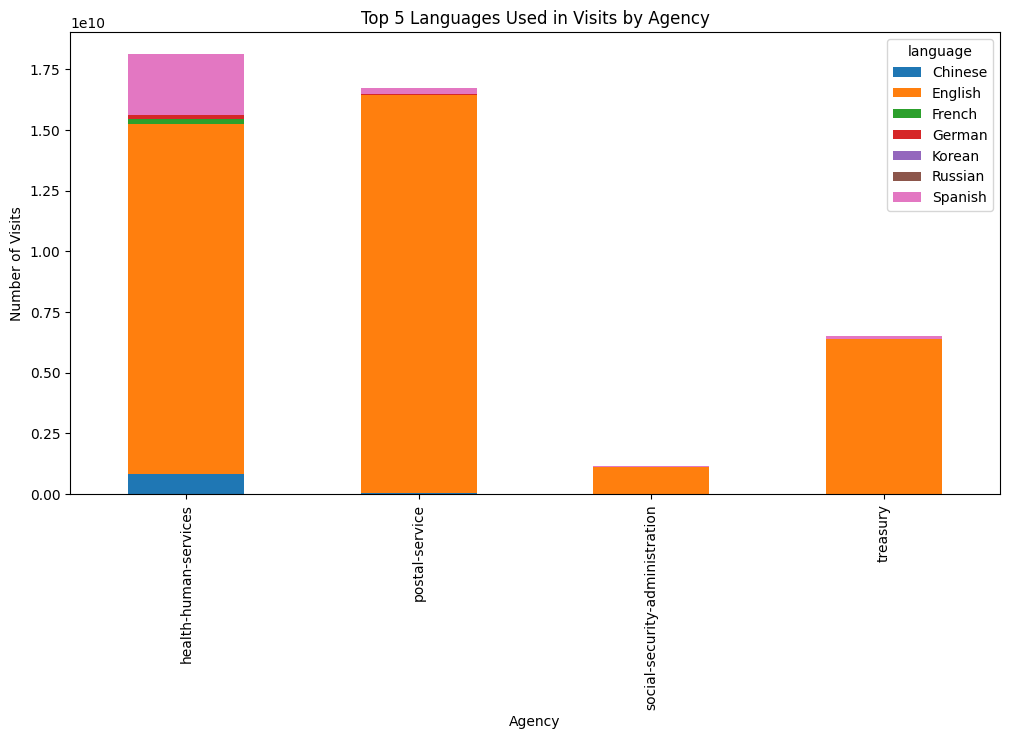

In [16]:
df_subset = df_languages[['report_agency', 'language', 'visits']]

df_grouped = df_subset.groupby(['report_agency', 'language']).sum().reset_index()

top_5_languages = df_grouped.groupby('report_agency').apply(lambda x: x.nlargest(5, 'visits'))

pivot_table = top_5_languages.pivot(index='report_agency', columns='language', values='visits')

ax = pivot_table.plot(kind='bar', stacked=True, figsize=(12,6))

ax.set_xlabel('Agency')
ax.set_ylabel('Number of Visits')
ax.set_title('Top 5 Languages Used in Visits by Agency')

plt.show()

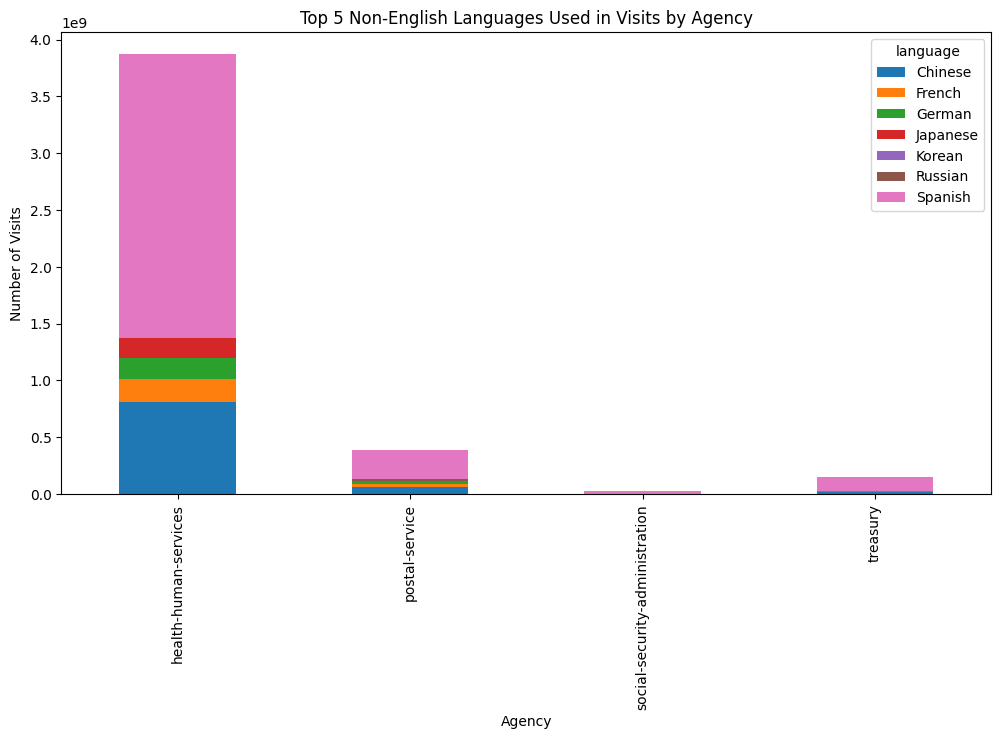

In [17]:
df_subset = df_languages[['report_agency', 'language', 'visits']]

df_non_english = df_subset[df_subset['language'] != 'English']

df_grouped = df_non_english.groupby(['report_agency', 'language']).sum().reset_index()

top_5_languages = df_grouped.groupby('report_agency').apply(lambda x: x.nlargest(5, 'visits'))

pivot_table = top_5_languages.pivot(index='report_agency', columns='language', values='visits')

ax = pivot_table.plot(kind='bar', stacked=True, figsize=(12,6))

ax.set_xlabel('Agency')
ax.set_ylabel('Number of Visits')
ax.set_title('Top 5 Non-English Languages Used in Visits by Agency')

plt.show()